In [1]:
!pip install --q anndata
!pip install --q decoupler
!pip install --q scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
   ━━━━━━━━━━━━━━━━

In [2]:
import scanpy as sc
import decoupler as dc
import numpy as np

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

In [3]:
adata = sc.datasets.pbmc3k()
adata

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

In [6]:
!pip3 install --q igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.4 MB/s eta 0:00:00


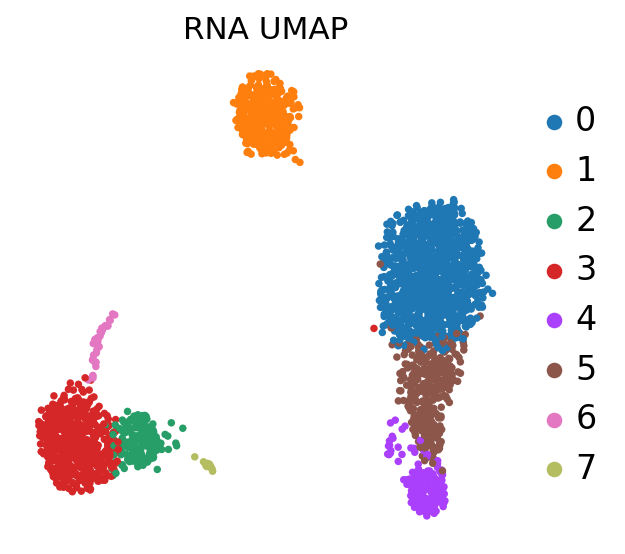

In [7]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Generate UMAP features
sc.tl.umap(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata, flavor='igraph', n_iterations=2, directed=False)

# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [8]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

In [9]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource(
    name='PanglaoDB',
    organism='human',
    license='academic'
)
markers

,genesymbol,_entity_type,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
,,,,,,,,,,,,,,
0,A0A068BD53,protein,True,B cells,Mesoderm,False,0.0,0.0,True,0.391473,0.00274026,10090,Immune system,0.007
1,A0A068BGV1,protein,True,Dendritic cells,Mesoderm,False,0.0,0.0,True,0.142857,0.000193013,10090,Immune system,0.0
2,A0A068BGW6,protein,True,B cells,Mesoderm,False,0.0,0.0,True,0.391473,0.00274026,10090,Immune system,0.007
3,A0A087WRN7,protein,False,Salivary mucous cells,Ectoderm,False,<NA>,<NA>,True,<NA>,<NA>,10090,Oral cavity,0.001
4,A0A0F6QAG2,protein,True,NK cells,Mesoderm,False,0.0,0.0,True,0.37234,0.000129107,10090,Immune system,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,ZNF521,protein,False,Adipocyte progenitor cells,Mesoderm,True,0.0,0.0103383,False,0.0,0.0,9606,Connective tissue,0.002
8457,ZNRF4,protein,False,Germ cells,Mesoderm,True,0.28436,0.0,True,0.0,0.0,9606,Reproductive,0.01
8458,ZPBP2,protein,True,Germ cells,Mesoderm,True,0.436019,0.0,True,0.0,0.0,9606,Reproductive,0.008


In [10]:
# Filter by canonical_marker and human
markers = markers[markers['human'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['human_sensitivity'].astype(float) > 0.5)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,_entity_type,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
,,,,,,,,,,,,,,
38,AAK1,protein,False,Neurons,Ectoderm,True,0.555556,0.0320452,True,0.470588,0.0213838,9606,Brain,0.044
50,ABCA3,protein,True,Pulmonary alveolar type II cells,Endoderm,True,0.692308,0.000943693,True,0.00757576,0.000517699,9606,Lungs,0.001
85,ACADVL,protein,False,Basal cells,Mesoderm,True,0.76,0.213018,True,1.0,0.00603183,9606,Epithelium,0.05
122,ACSL5,protein,True,Enterocytes,Endoderm,True,0.666667,0.0153798,True,0.728477,0.0501211,9606,GI tract,0.055
133,ACTA2,protein,True,Smooth muscle cells,Mesoderm,True,0.904762,0.0135604,True,1.0,0.0313632,9606,Smooth muscle,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8383,WT1,protein,False,Mesothelial cells,Mesoderm,True,1.0,0.0219436,True,0.0,0.0,9606,Epithelium,0.01
8387,XCL1,protein,False,Decidual cells,<NA>,True,1.0,0.00971482,True,0.0,0.0,9606,Reproductive,0.006
8389,XCL2,protein,False,Decidual cells,<NA>,True,1.0,0.0103416,False,0.0,0.0,9606,Reproductive,0.002


In [11]:
dc.show_resources()

['Adhesome',
 'Almen2009',
 'Baccin2019',
 'CORUM_Funcat',
 'CORUM_GO',
 'CPAD',
 'CSPA',
 'CSPA_celltype',
 'CancerDrugsDB',
 'CancerGeneCensus',
 'CancerSEA',
 'CellCall',
 'CellCellInteractions',
 'CellChatDB',
 'CellChatDB_complex',
 'CellPhoneDB',
 'CellPhoneDB_complex',
 'CellTalkDB',
 'CellTypist',
 'Cellinker',
 'Cellinker_complex',
 'ComPPI',
 'CytoSig',
 'DGIdb',
 'DisGeNet',
 'EMBRACE',
 'Exocarta',
 'GO_Intercell',
 'GPCRdb',
 'Guide2Pharma',
 'HGNC',
 'HPA_secretome',
 'HPA_subcellular',
 'HPA_tissue',
 'HPMR',
 'HumanCellMap',
 'ICELLNET',
 'ICELLNET_complex',
 'IntOGen',
 'Integrins',
 'InterPro',
 'KEGG',
 'KEGG-PC',
 'Kirouac2010',
 'LOCATE',
 'LRdb',
 'Lambert2018',
 'MCAM',
 'MSigDB',
 'Matrisome',
 'MatrixDB',
 'Membranome',
 'NetPath',
 'OPM',
 'PROGENy',
 'PanglaoDB',
 'Phobius',
 'Phosphatome',
 'Ramilowski2015',
 'Ramilowski_location',
 'SIGNOR',
 'SignaLink_function',
 'SignaLink_pathway',
 'Surfaceome',
 'TCDB',
 'TFcensus',
 'TopDB',
 'UniProt_family',
 'UniP

In [12]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 49 sources.


  0%|          | 0/2638 [00:00<?, ?it/s]

In [13]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'
    varm: 'PCs'
    layers: 'log_norm'
    obsp: 'distances', 'connectivities'

In [15]:
adata.obsm["ora_estimate"]

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Basal cells,Decidual cells,Dendritic cells,Ductal cells,Endothelial cells,...,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells,T cells naive,T memory cells,Undefined placental cells
AAACATACAACCAC-1,-0.000000,1.036748,0.885021,4.739890,2.641014,0.613213,0.723628,5.546258,-0.000000,-0.000000,...,0.437907,1.871866,-0.000000,-0.0,-0.0,-0.0,11.728494,2.462920,6.821860,-0.000000
AAACATTGAGCTAC-1,-0.000000,-0.000000,0.885021,7.799678,13.894150,-0.000000,-0.000000,14.296287,0.885021,0.827013,...,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581,1.002545,2.981581,-0.000000
AAACATTGATCAGC-1,-0.000000,0.389675,0.885021,3.427795,6.107693,-0.000000,0.723628,4.388220,-0.000000,0.298770,...,0.437907,3.976687,-0.000000,-0.0,-0.0,-0.0,11.728494,2.462920,11.728494,-0.000000
AAACCGTGCTTCCG-1,0.613213,1.036748,0.885021,2.268076,2.641014,1.542530,-0.000000,24.208278,0.885021,0.827013,...,-0.000000,8.019237,0.613213,-0.0,-0.0,-0.0,1.957728,-0.000000,1.089237,-0.000000
AAACCGTGTATGCG-1,-0.000000,-0.000000,0.885021,1.278757,0.943623,0.613213,1.793827,11.043176,-0.000000,0.298770,...,0.437907,2.858756,-0.000000,-0.0,-0.0,-0.0,1.957728,-0.000000,1.089237,1.002545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.613213,1.036748,0.885021,3.427795,2.641014,0.613213,-0.000000,26.647907,0.885021,1.527899,...,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581,-0.000000,-0.000000,-0.000000
TTTCTACTGAGGCA-1,-0.000000,-0.000000,0.885021,4.739890,2.641014,0.613213,-0.000000,9.543575,2.171878,0.827013,...,1.146495,3.976687,-0.000000,-0.0,-0.0,-0.0,2.981581,-0.000000,0.412702,-0.000000
TTTCTACTTCCTCG-1,-0.000000,-0.000000,0.885021,11.490976,17.770927,-0.000000,-0.000000,16.056578,-0.000000,-0.000000,...,1.146495,2.858756,-0.000000,-0.0,-0.0,-0.0,2.981581,1.002545,4.140366,-0.000000
TTTGCATGAGAGGC-1,-0.000000,-0.000000,-0.000000,4.739890,7.468516,-0.000000,-0.000000,12.626595,-0.000000,-0.000000,...,1.146495,2.858756,-0.000000,-0.0,-0.0,-0.0,2.981581,-0.000000,0.412702,1.002545


In [16]:
adata.obsm["ora_pvals"]

source,Acinar cells,Adipocytes,Alpha cells,B cells,B cells naive,Basal cells,Decidual cells,Dendritic cells,Ductal cells,Endothelial cells,...,Plasmacytoid dendritic cells,Platelets,Podocytes,Proximal tubule cells,Pulmonary alveolar type II cells,Smooth muscle cells,T cells,T cells naive,T memory cells,Undefined placental cells
AAACATACAACCAC-1,1.000000,0.091887,0.13031,1.820162e-05,2.285523e-03,0.243661,0.188961,2.842771e-06,1.000000,1.000000,...,0.364832,1.343180e-02,1.000000,1.0,1.0,1.0,1.868556e-12,0.003444,1.507093e-07,1.000000
AAACATTGAGCTAC-1,1.000000,1.000000,0.13031,1.586067e-08,1.275999e-14,1.000000,1.000000,5.054906e-15,0.130310,0.148932,...,0.071368,1.055148e-04,1.000000,1.0,1.0,1.0,1.043322e-03,0.099416,1.043322e-03,1.000000
AAACATTGATCAGC-1,1.000000,0.407685,0.13031,3.734265e-04,7.803824e-07,1.000000,0.188961,4.090537e-05,1.000000,0.502609,...,0.364832,1.055148e-04,1.000000,1.0,1.0,1.0,1.868556e-12,0.003444,1.868556e-12,1.000000
AAACCGTGCTTCCG-1,0.243661,0.091887,0.13031,5.394163e-03,2.285523e-03,0.028673,1.000000,6.190447e-25,0.130310,0.148932,...,1.000000,9.566722e-09,0.243661,1.0,1.0,1.0,1.102230e-02,1.000000,8.142592e-02,1.000000
AAACCGTGTATGCG-1,1.000000,1.000000,0.13031,5.263117e-02,1.138614e-01,0.243661,0.016076,9.053662e-12,1.000000,0.502609,...,0.364832,1.384343e-03,1.000000,1.0,1.0,1.0,1.102230e-02,1.000000,8.142592e-02,0.099416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.243661,0.091887,0.13031,3.734265e-04,2.285523e-03,0.243661,1.000000,2.249538e-27,0.130310,0.029655,...,0.071368,1.055148e-04,1.000000,1.0,1.0,1.0,1.043322e-03,1.000000,1.000000e+00,1.000000
TTTCTACTGAGGCA-1,1.000000,1.000000,0.13031,1.820162e-05,2.285523e-03,0.243661,1.000000,2.860385e-10,0.006732,0.148932,...,0.071368,1.055148e-04,1.000000,1.0,1.0,1.0,1.043322e-03,1.000000,3.866321e-01,1.000000
TTTCTACTTCCTCG-1,1.000000,1.000000,0.13031,3.228675e-12,1.694621e-18,1.000000,1.000000,8.778532e-17,1.000000,1.000000,...,0.071368,1.384343e-03,1.000000,1.0,1.0,1.0,1.043322e-03,0.099416,7.238253e-05,1.000000
TTTGCATGAGAGGC-1,1.000000,1.000000,1.00000,1.820162e-05,3.400038e-08,1.000000,1.000000,2.362683e-13,1.000000,1.000000,...,0.071368,1.384343e-03,1.000000,1.0,1.0,1.0,1.043322e-03,1.000000,3.866321e-01,0.099416


In [17]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# Have to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 2638 × 49
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals'

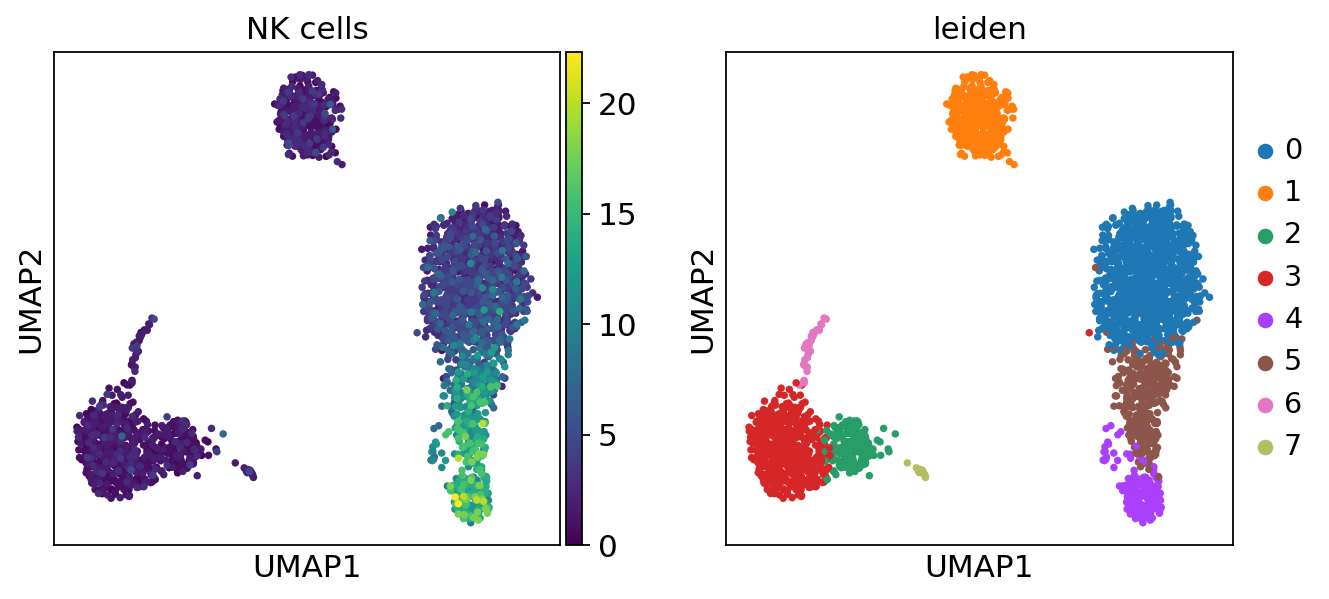

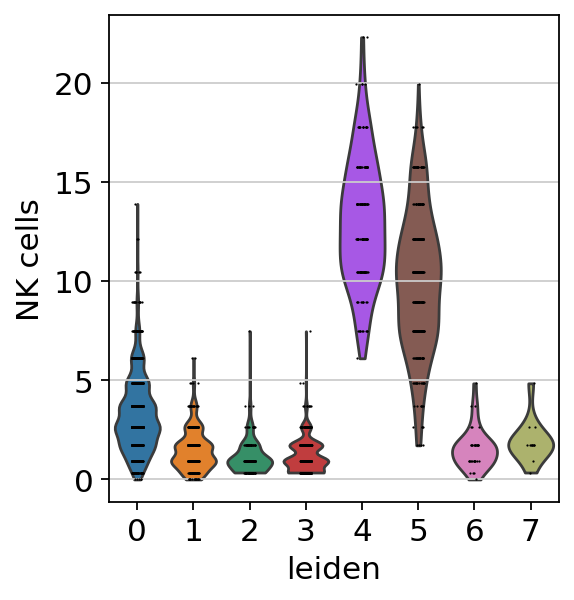

In [18]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='viridis')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

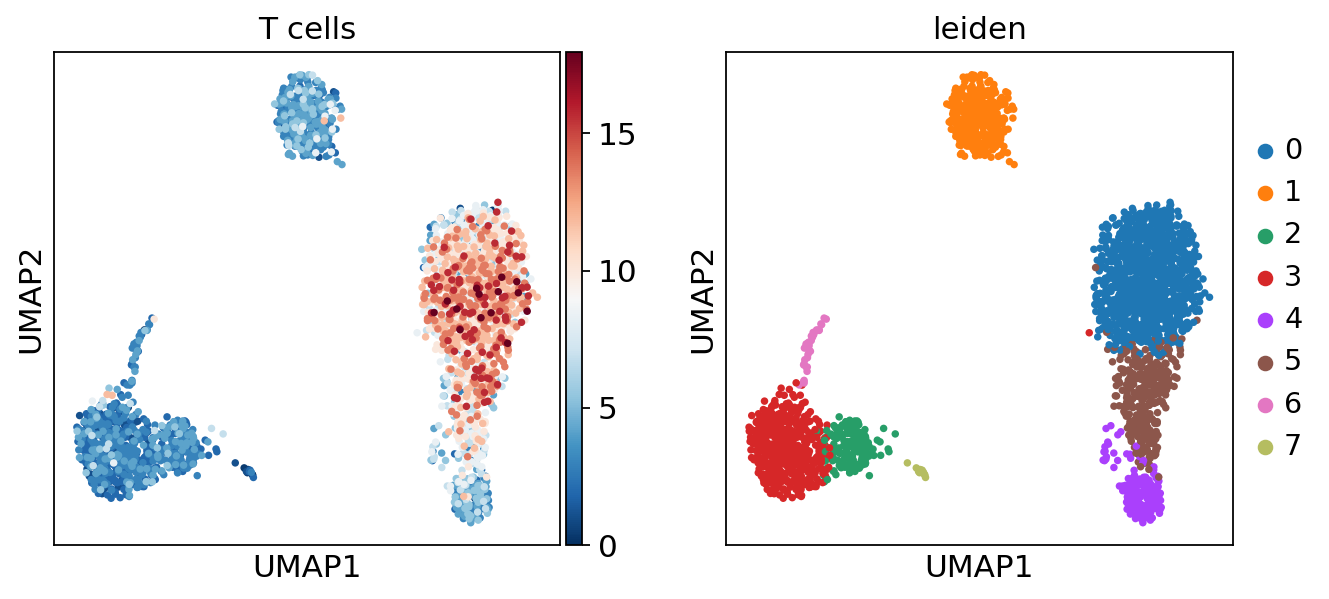

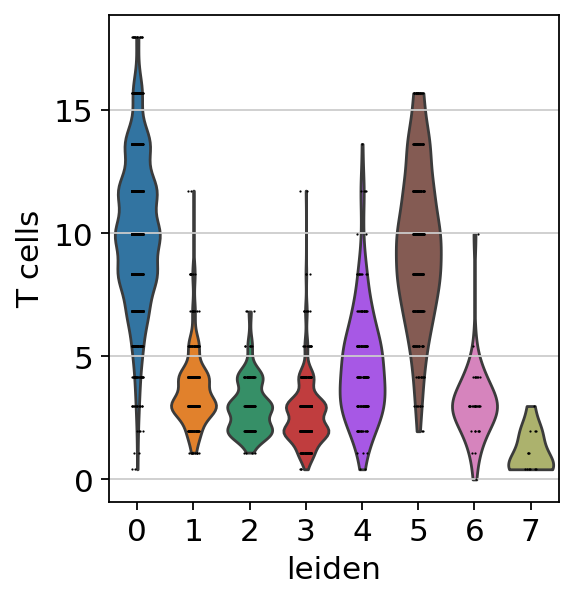

In [24]:
sc.pl.umap(acts, color=['T cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['T cells'], groupby='leiden')

In [22]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,T memory cells,42.536034,4.935439,2.348527e-291,1.150778e-289
1,0,rest,T cells,42.085754,5.528636,6.198598e-287,1.518656e-285
2,0,rest,T cells naive,32.733807,1.412627,2.460421e-186,3.014015e-185
3,0,rest,Neurons,9.927038,0.167912,9.410941e-23,2.882101e-22
4,0,rest,Decidual cells,6.260683,0.217555,4.714176e-10,1.004324e-09
...,...,...,...,...,...,...,...
387,7,rest,B cells,-3.160391,-2.461333,5.329793e-03,1.374526e-02
388,7,rest,Ductal cells,-3.456581,-0.625260,3.285145e-03,1.057917e-02
389,7,rest,T cells naive,-3.471092,-1.177413,4.621649e-03,1.258115e-02
390,7,rest,T memory cells,-3.990191,-4.116628,1.682183e-03,6.340535e-03


In [25]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['T memory cells', 'T cells', 'T cells naive'],
 '1': ['B cells naive', 'B cells', 'Langerhans cells'],
 '2': ['Macrophages', 'Dendritic cells', 'Monocytes'],
 '3': ['Neutrophils', 'Dendritic cells', 'Acinar cells'],
 '4': ['Gamma delta T cells', 'NK cells', 'Decidual cells'],
 '5': ['NK cells', 'Gamma delta T cells', 'Decidual cells'],
 '6': ['Langerhans cells', 'Dendritic cells', 'Ductal cells'],
 '7': ['Platelets', 'Endothelial cells', 'Hepatic stellate cells']}

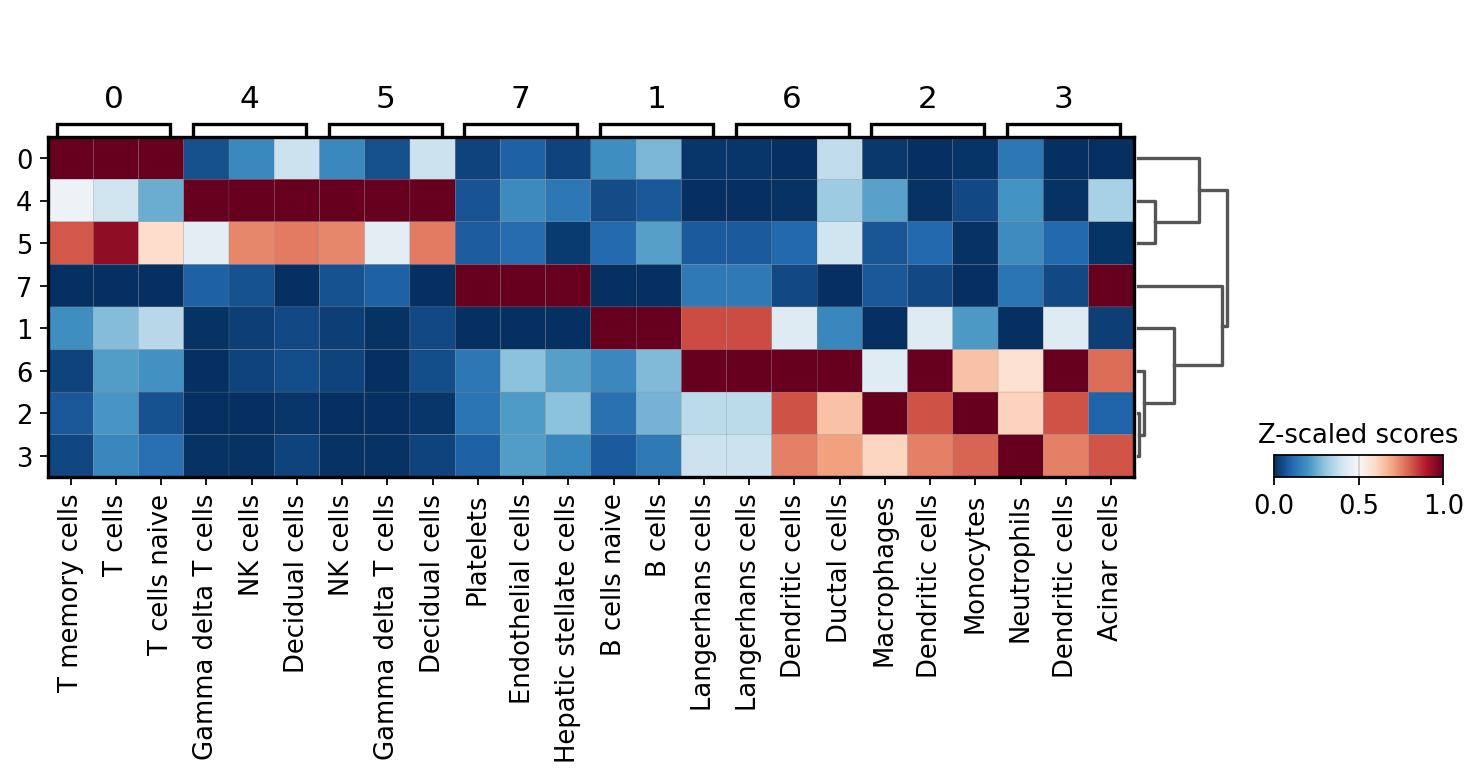

In [26]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

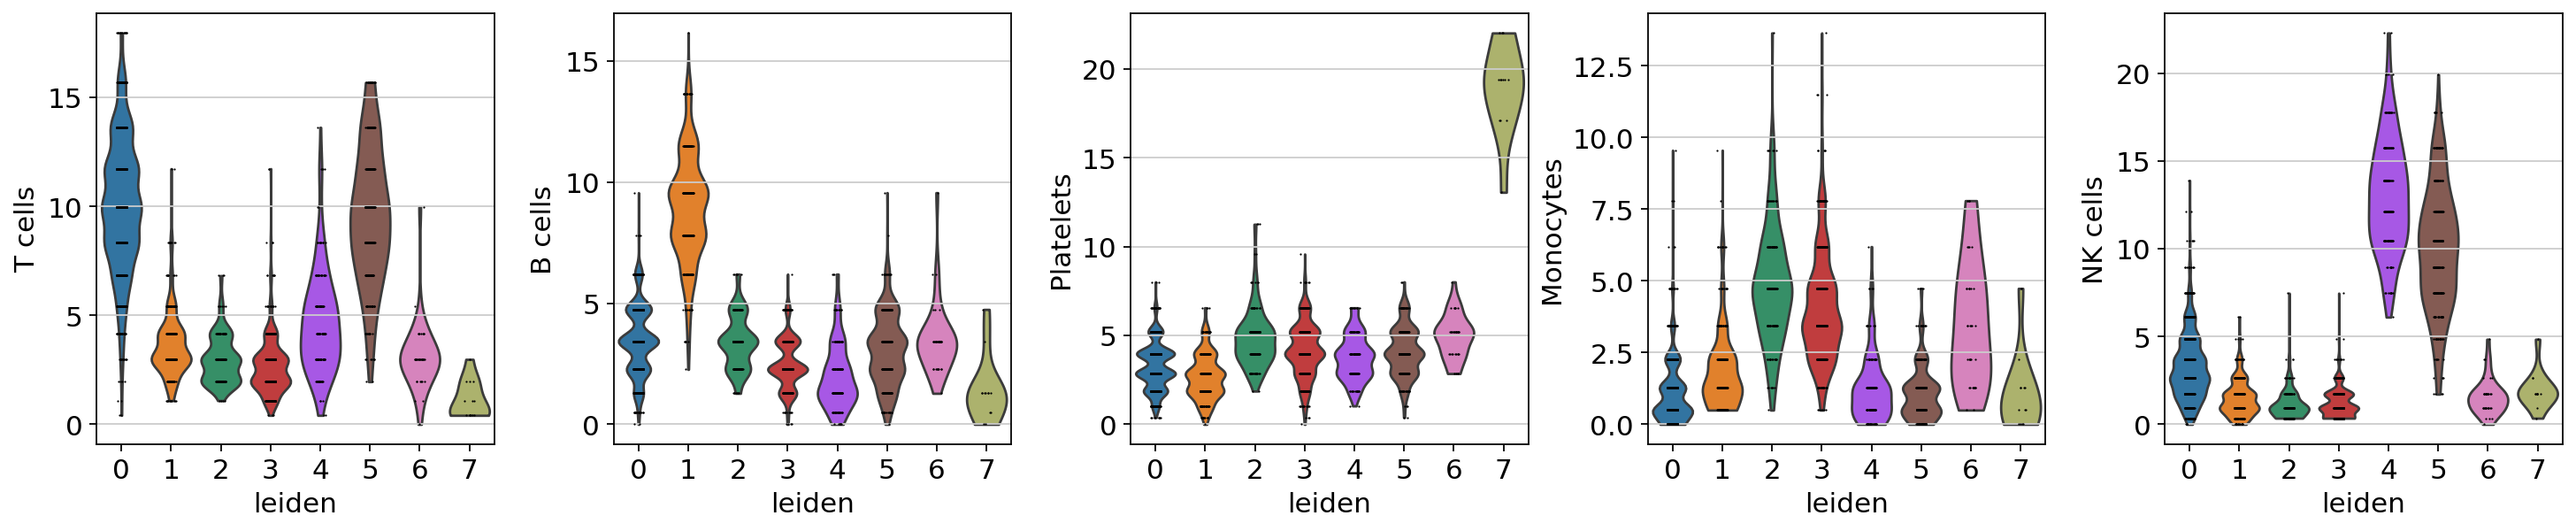

In [27]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

In [28]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'T memory cells',
 '1': 'B cells naive',
 '2': 'Macrophages',
 '3': 'Neutrophils',
 '4': 'Gamma delta T cells',
 '5': 'NK cells',
 '6': 'Langerhans cells',
 '7': 'Platelets'}

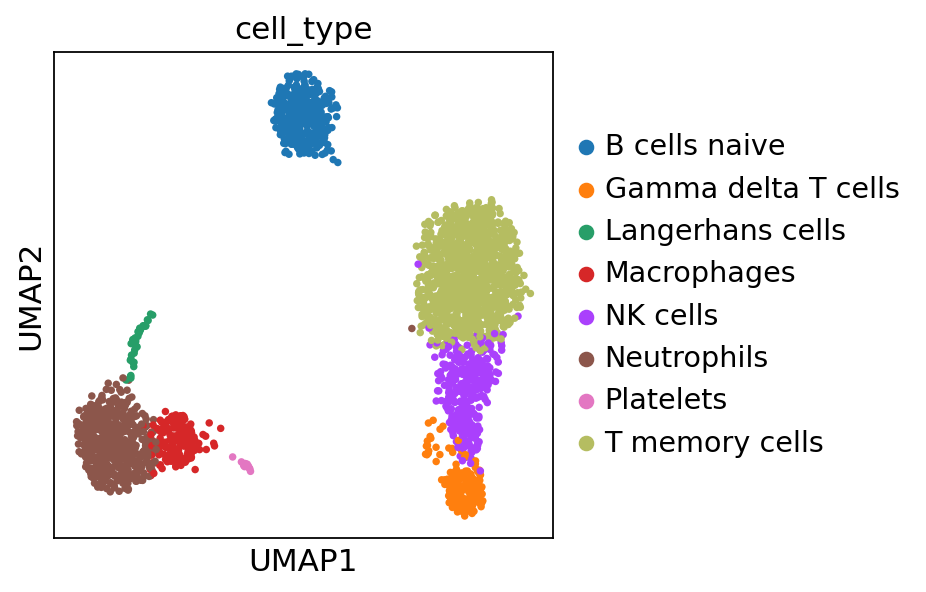

In [29]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')